# Advanced Lane Line Finding
## Udacity Self-Driving Car Nanodegree

### By Wonjun Lee
---

### Overview

This project is to recognize the lanes from the video taken from the camera attached to the car using distortion correction, color transforms, gradients, etc.

Videos and images used in this project are all from Udacity.

The raw data can be found from https://github.com/udacity/CarND-Advanced-Lane-Lines

Below is the summary of the process of the project.

1. Calibration
2. Unwarping
3. Edge Detection
4. Finding Lanes

---

# Computing the camera calibration matrix and distortion coefficients

To calibrate the camera, I will use photos of chess boards and use several functions from **cv2** library.

In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
%matplotlib inline

# Load chessboard images
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)

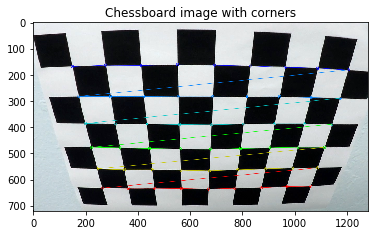

In [2]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for i in range(1,21):
    fname = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)

camera_cal/calibration2.jpg
camera_cal/calibration3.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration20.jpg


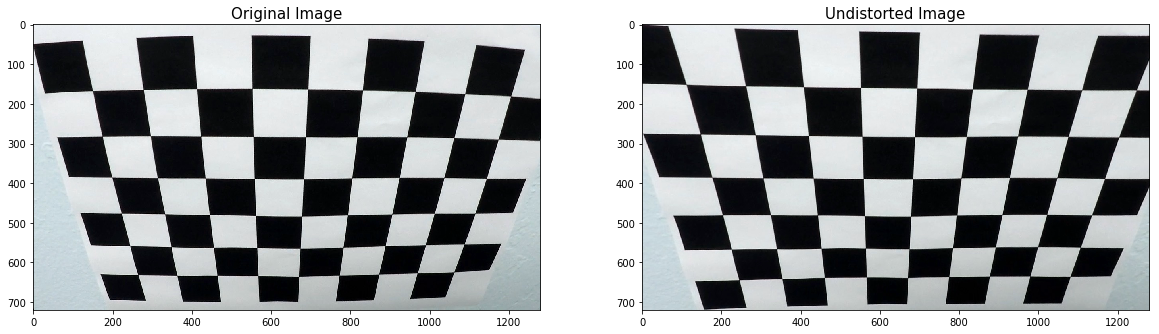

In [4]:
# Test undistortion on an image
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)


---
# Edge Detection

We now have a calibration function.

I will create a function that would detect the edges from the photos.

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("function for masking region of interest")

function for masking region of interest


In [6]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

print("Functions for edge dections are created")

Functions for edge dections are created


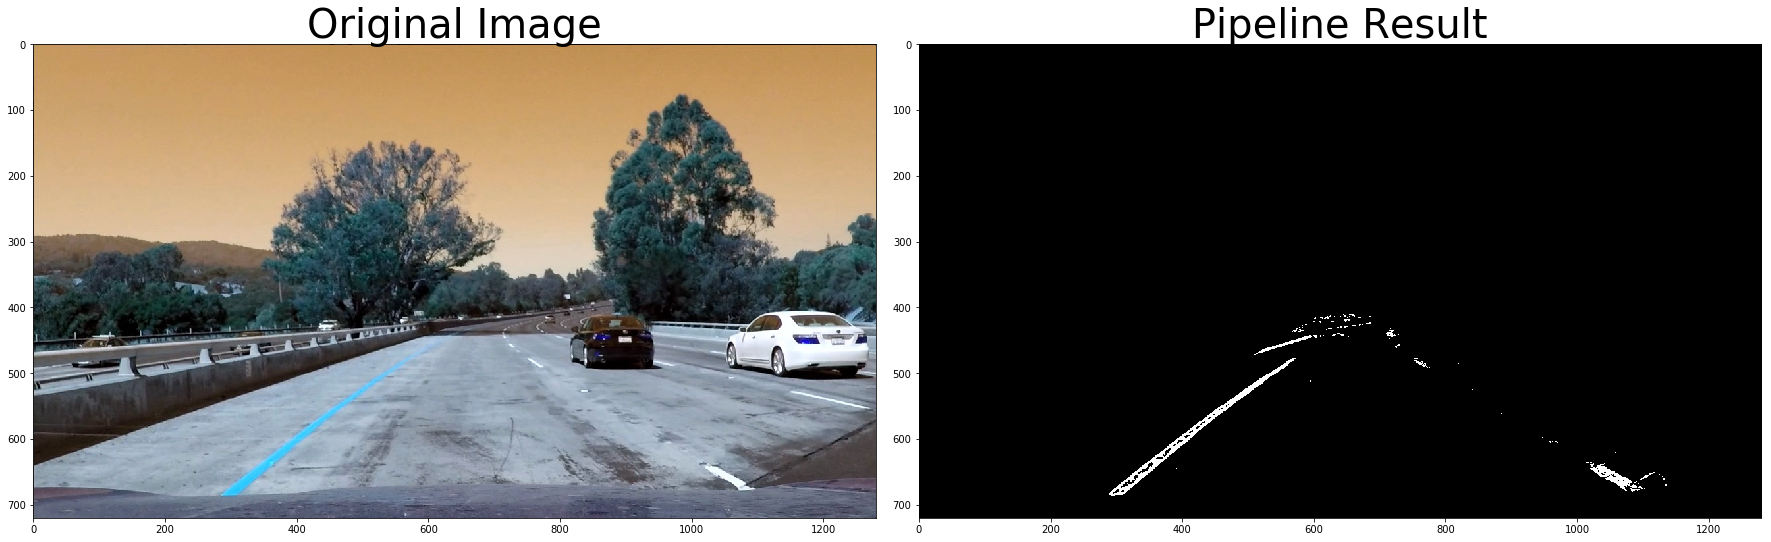

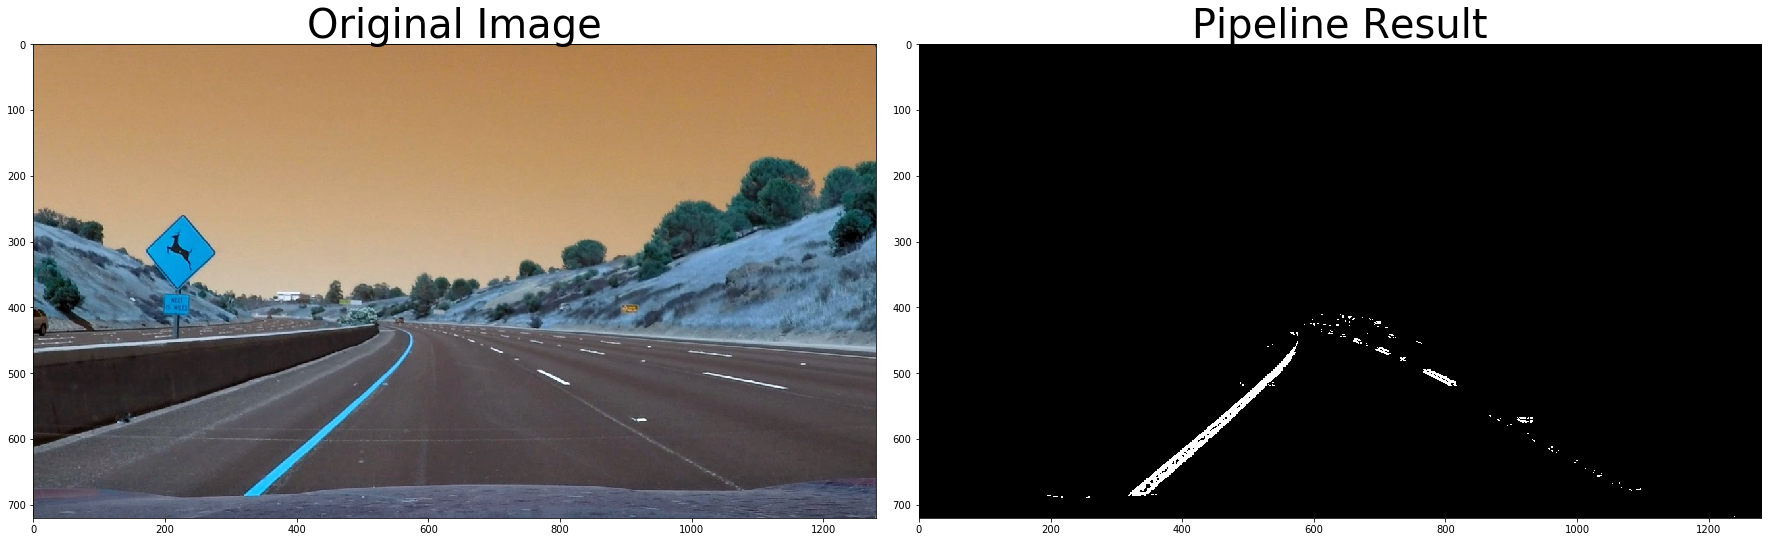

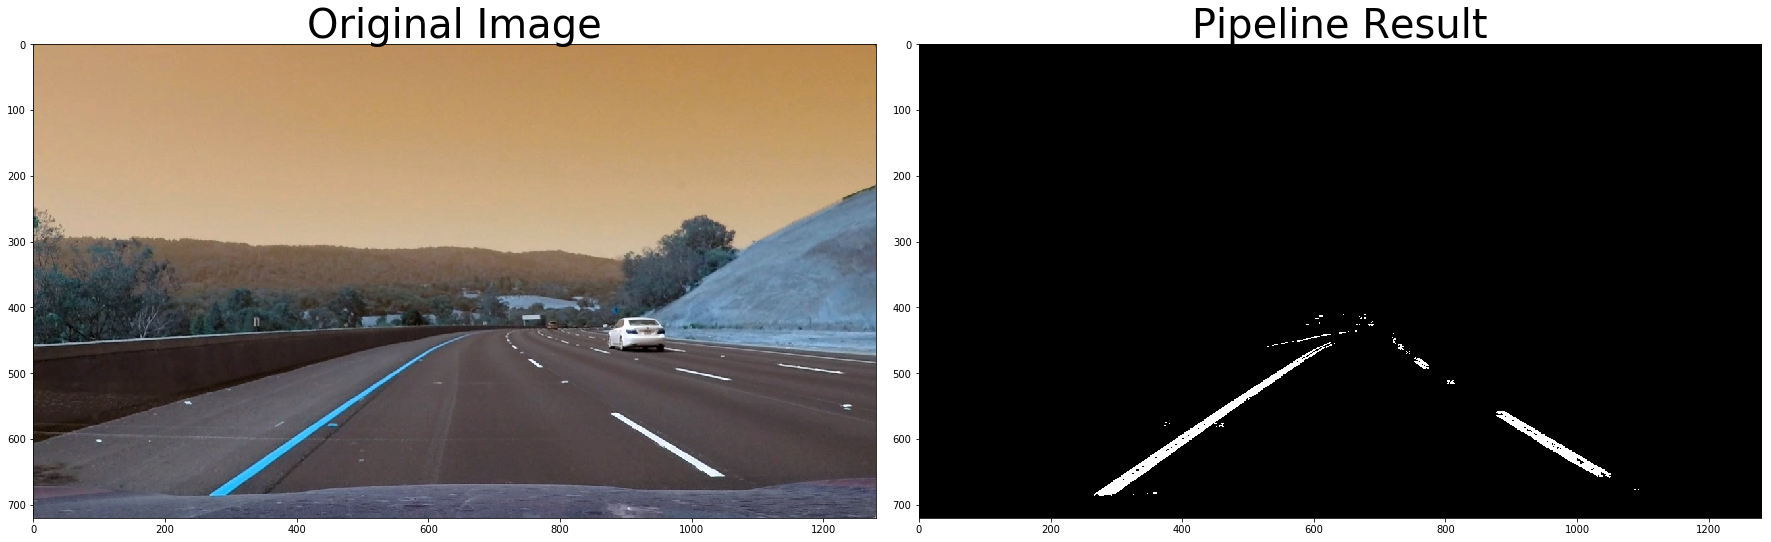

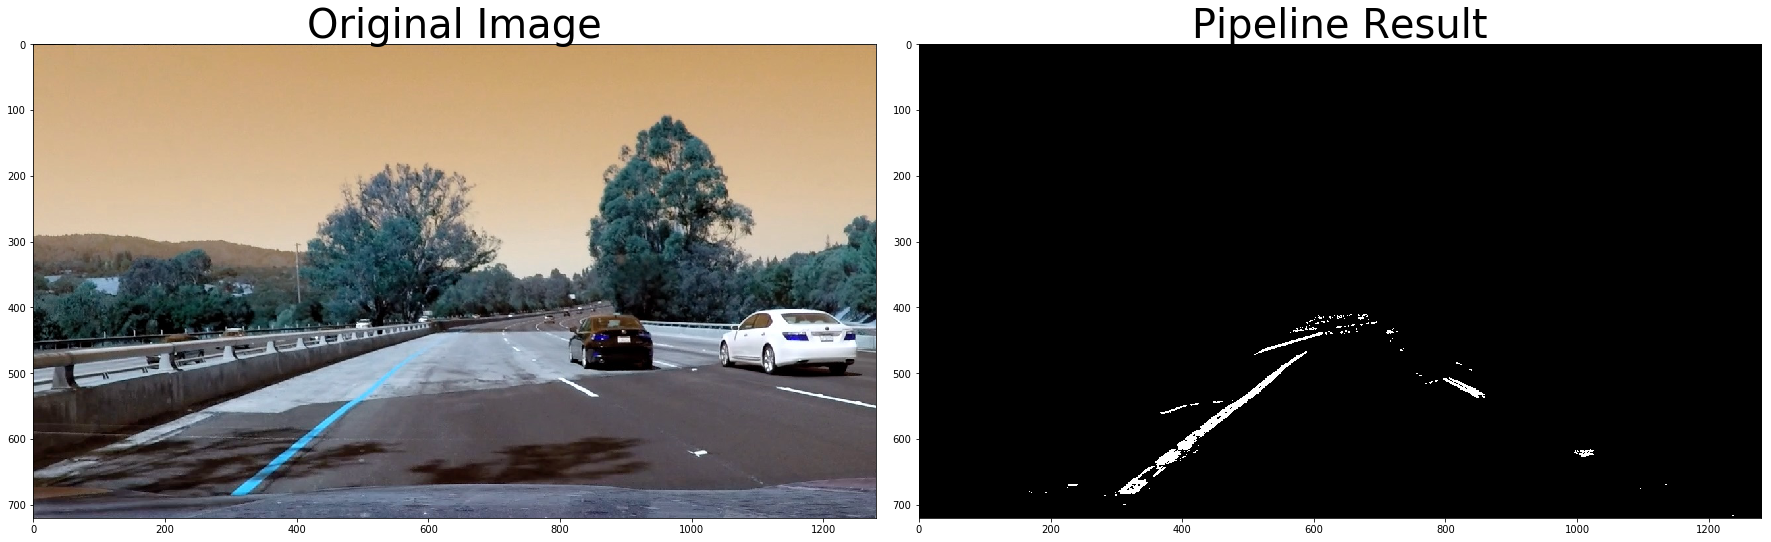

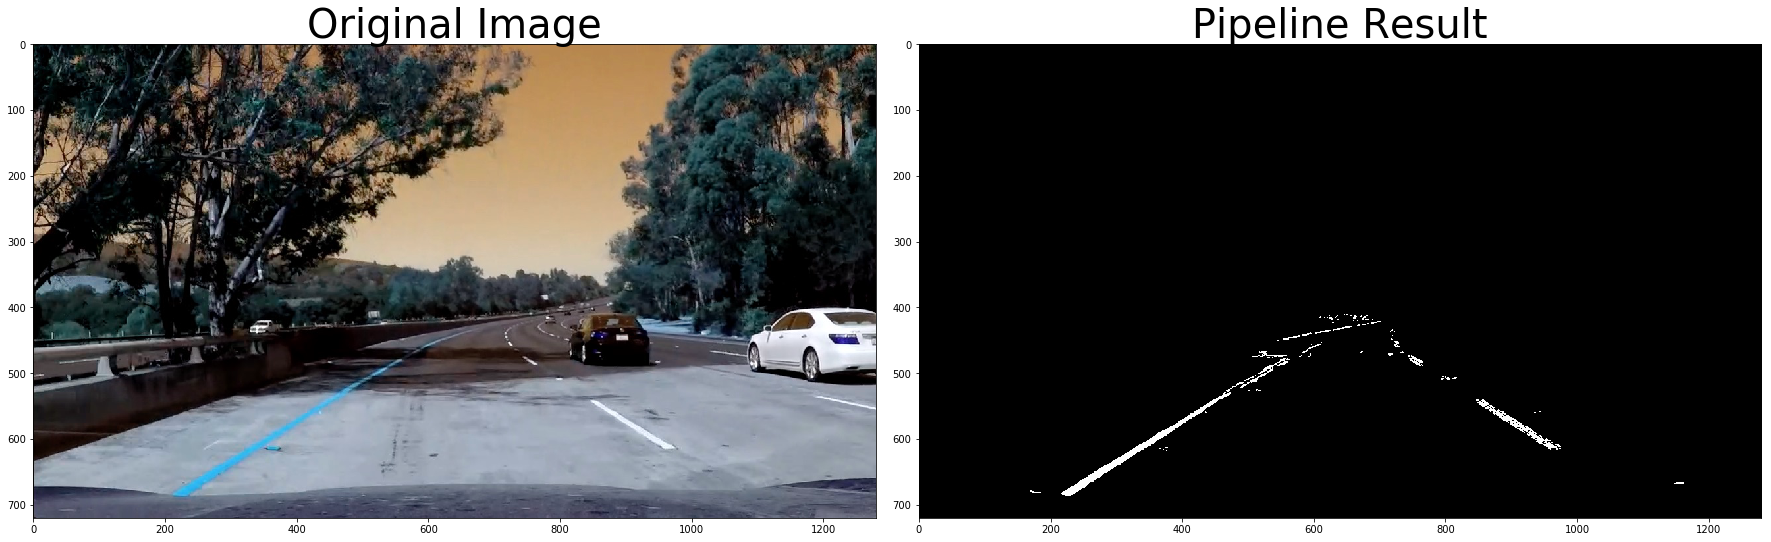

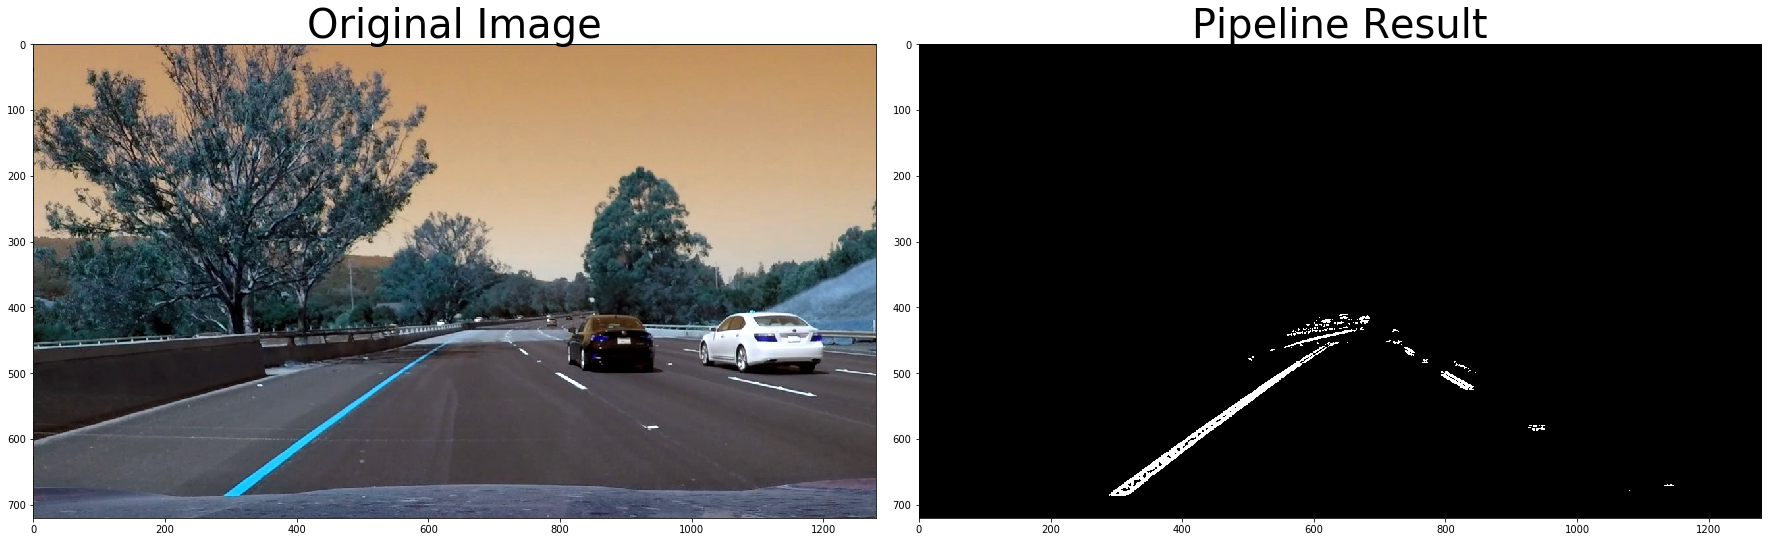

In [7]:
# Edit this function to create your own pipeline.
def pipeline(img):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary
    
for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    result = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In the above script, I used multiple methods of edge detections to detect the edges from the image and used the masking function to avoid having any noises.

Here are **6** methods that I used for the edge detection function.
- Gaussian Blurring to reduce noises
- Sober Operator x-direction
- Sober Operator y-direction
- Direction of Gradient
- Magnitude of Gradient
- HLS Color Threshold

Now that we have a function for the edge detection, let's move on to the warping function.

---
# Warping Function

The lanes are warped from the camera's perspective. I will create a function that will unwarp the lanes.

This will look like bird eye view photos from above.

In [8]:
# Define image shape
image_shape = image.shape
print("image shape:",image_shape)

# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

print("corner_unwarp function is created")

image shape: (720, 1280, 3)
corner_unwarp function is created


Warping function is created. The hardest part on this function was to find the most appropriate **area_of_interest**.

We now have **corners_unwarp** function, let's create the functions to detect lanes and shade the areas.

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1
        
print("line class is defined")

line class is defined


The function below is used to calculate the curvature. I used the function given from Udacity.

And the second function is to calculate the car's position from the center of the road.

This second function will tell us if car is left or right to the center.

In [10]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

Below functions are accessory functions that will be used in **fit_lanes** function.

In [11]:
def find_nearest(array,value):
    # Function to find the nearest point from array
    if len(array) > 0:
        idx = (np.abs(array-value)).argmin()
        return array[idx]

def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2        

def sanity_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

# Sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    # If the direction is ok then pass
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .2:
        return right
    # If not then compute the value from the previous values
    else:
        return right_pre + (right_pre - right_pre2)
    
# find_lanes function will detect left and right lanes from the warped image.
# 'n' windows will be used to identify peaks of histograms    
def find_lanes(n, image, x_window, lanes, \
               left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set index1. This is used for placeholder.
    index1 = np.zeros((n+1,2))
    index1[0] = [300, 1100]
    index1[1] = [300, 1100]
    # Set the first left and right values
    left, right = (300, 1100)
    # Set the center
    center = 700
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    for i in range(n-1):
        # set the window range.
        y_window_top = 720-720/n*(i+1)
        y_window_bottom = 720-720/n*i
        # If left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # Find the historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            # Set the direction
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            # Set the center
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > 600:
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
            # Append coordinates to the right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

print("Accessory functions are created")

Accessory functions are created


**fit_lanes** function will take the warped image and it will find the lanes from the set of pixels.

The warped image will be divided into several pieces horizontally and the histogram will be drawn from each division by summing the pixel values over x-axis.

I expect that the peak from the histogram to be the position of lanes from each division.

These position values of lanes will be saved in left_lane_x,y and right_lane_x,y.

Then, I will use **np.poly_fit** to find the appropriate quadratic formulas that fit these lanes.

In [12]:
import math
# Function to find the fitting lines from the warped image
def fit_lanes(image):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left = None
    right = None
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    # Find curvatures
    left_curverad  = find_curvature(yvals, left_fitx)
    right_curverad = find_curvature(yvals, right_fitx)
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad

print("fit_lanes are done")

fit_lanes are done


In [13]:
# draw poly on an image
# def draw_poly(image, warped, yvals, left_fitx, right_fitx, Minv):
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result

print("Draw poly on a original image")

Draw poly on a original image


In [14]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = pipeline(image)
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    # Find the lines fitting to left and right lanes
    a, b, c, lx, ly, rx, ry, curvature = fit_lanes(top_down)
    # Return the original image with colored region
    return draw_poly(image, top_down, a, b, c, lx, ly, rx, ry, perspective_Minv, curvature)

---
# Image Processing

All of functions that are required to shade the areas between the lanes are ready.

We will be using these function on several example photos.

TypeError: slice indices must be integers or None or have an __index__ method

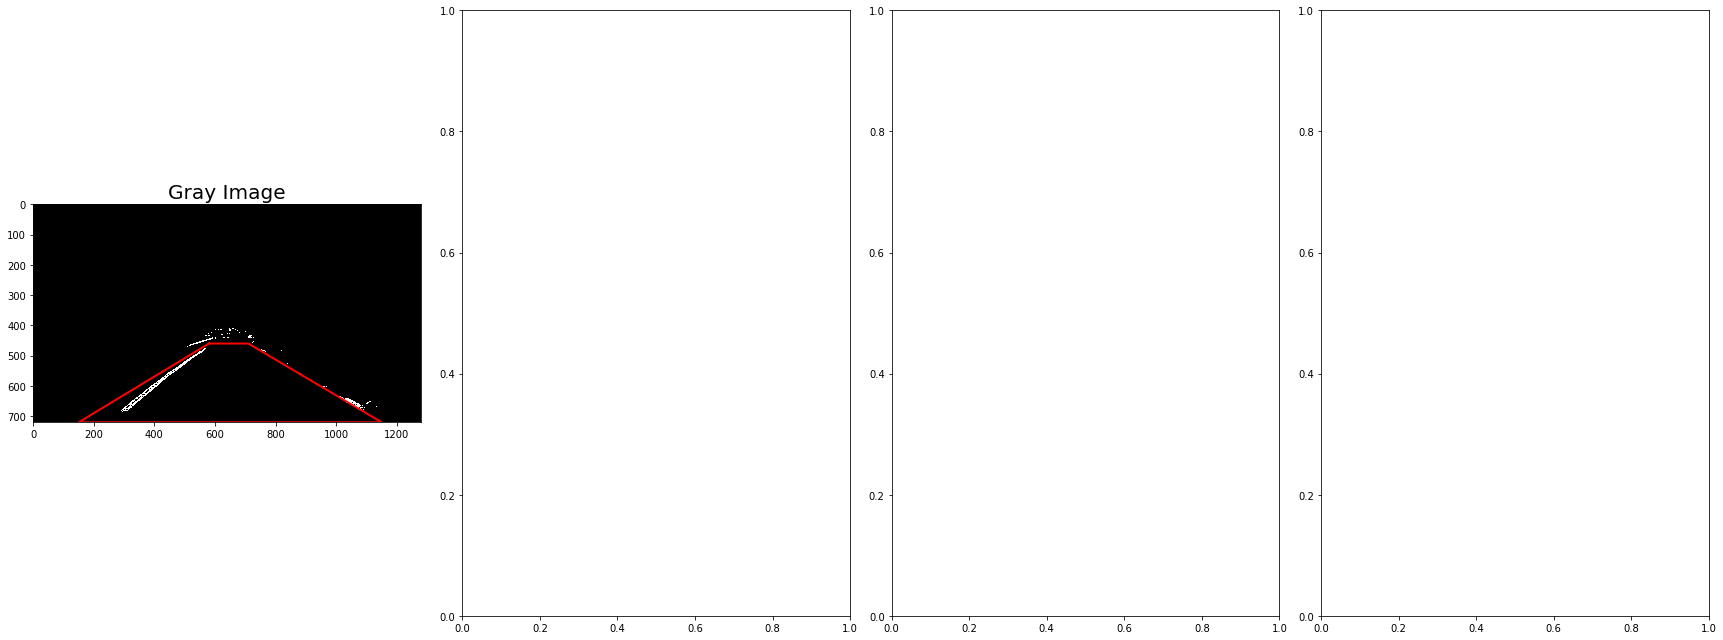

In [15]:
# These are to be used to plot lines on images
x_values = [area_of_interest[0][0],area_of_interest[1][0],area_of_interest[2][0],area_of_interest[3][0],area_of_interest[0][0]]
y_values = [area_of_interest[0][1],area_of_interest[1][1],area_of_interest[2][1],area_of_interest[3][1],area_of_interest[0][1]]

# Plot 6 example images and warp them
for i in range(1,7):
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()
    # load the image
    fname = 'test_images/test{}.jpg'.format(i)
    img_raw = cv2.imread(fname)
    # Apply pipeline to the image to create black and white image
    img = pipeline(img_raw)
    # Unwrap the image
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    # Set up for the subplots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    # Showing the image from pipeline with marked areas
    ax1.set_title('Gray Image', fontsize=20)
    ax1.plot(x_values,y_values,'r-',lw=2)
    ax1.imshow(img, cmap='gray')
    # Find lanes from the warped image
    a, b, c, _, _, _, _, _ = fit_lanes(top_down)
    ax2.plot(b, a, color='green', linewidth=5)
    ax2.plot(c, a, color='blue', linewidth=5)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()    
    # Use the information from fit_lane function to color the lanes
    image_color = process_image(img_raw)
    ax3.imshow(image_color)
    ax3.set_title('Image with a color', fontsize=20)
    # Plot three histograms
    top_down[top_down > 0] = 1
    histogram = np.sum(top_down[:240,:], axis=0)
    ax4.plot(histogram)
    histogram = np.sum(top_down[240:480,:], axis=0)
    ax4.plot(histogram)
    histogram = np.sum(top_down[480:,:], axis=0)
    ax4.plot(histogram)
    indexes = find_peaks_cwt(histogram, np.arange(1, 550))
    ax4.set_title("histogram")
    # Adjusting subplots
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)   

---
# Video Processing

We are going to apply our model on a sample video.

The video is about 50 seconds long and the result video will shade the area between lanes and indicate the curvature and the position of the car.

In [200]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [07:55<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 12min 31s, sys: 1min 48s, total: 14min 19s
Wall time: 7min 56s


---
# Conclusion

You can check the final result from *white.mp4* and you can see that the model identifies the lanes correctly. When the abnormal lanes that is way different from the previous lanes are detected from the model, the sanity function use the previous lane values and avoid any abnormality.

My warping function does not show the completely parallel lanes, so when I plot the quadratic functions to fit the lanes, there are big differences between coefficients of polynomials from left and right lanes. I only used the left lane to calculate the curvature. For the position, I assumed **640** (which is the middle of the x-dimensional pixels) to be the position of the car. I calculate the center of lanes and indicate the position of the car from the center on video.

It took me more than **20** hours to complete the project mainly because I had to find the most appropriate parameters for the edge detection and the warping function. I also tried a lot of different methods of detecting lanes from warped images. After all of these were done, I spent time on completing the sanity check function. I found that in my model, just checking **curvature** values provided the best result. 

The model can be improved if I could improve the edge detection function using different parameters or using entirely different methods for the edge detection. So, reducing noises from images is the key point of improving the model.

The model fails when the image contains shades, and it will fail under many circumstances such as harsh weather conditions (snow, rain, fog, etc). In order to improve the model to successfully identify the lanes under theses conditions, we need to use a better way of reducing noises from images.